# Pipline experiments

In [1]:
import os
import sys
import random
import pickle
from datetime import datetime

import albumentations as albu
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import jpeg4py as jpeg
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import (
    Dataset, 
    DataLoader, 
    SubsetRandomSampler,
    SequentialSampler,
    Sampler)
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold

from configs import (
    TRAIN_NON_EMPTY_PATH,
    TRAIN_PATH,
    TEST_PATH,
    IMAGES_TO_EXCLUDE,
    IMAGES_TO_EXCLUDE2
)
from utils import (
    rle2mask,
    mask2rle,
    show_images_with_defects,
    plot_loss_metrics,
    plot_batch_metrics,
    _fix_seeds
)
from samplers import ClassProbSampler, SubsetRandomSampler
from datasets import SteelTrainDataset
from losses import (
    BCEDiceLoss,
    BCELogitsLoss,
    BCEDiceWeightedLoss,
    BCEWeightedLoss,
    TverskyWeightedLoss
)
from trainers import Trainer

%matplotlib inline
device = torch.device("cuda:0")
#device = torch.device("cpu")

with open('../input_data/train_dict.pcl', 'rb') as handle:
    train_dict = pickle.load(handle)
    
with open('../input_data/train_class_images.pcl', 'rb') as handle:
    train_class_images = pickle.load(handle)
    
with open('../input_data/train_image_class.pcl', 'rb') as handle:
    train_image_class = pickle.load(handle)

## Cross validation 5 folds

In [2]:
print(len(IMAGES_TO_EXCLUDE2))
exclude_img_list = list(set(IMAGES_TO_EXCLUDE2))
print(len(exclude_img_list))

479
344


In [3]:
class_weights_sampler = {
    0: 1,#64/29.,
    1: 1,#64/4.,
    2: 1,#64/2.,
    3: 1,#64/25.,
    4: 1,#64/4.,    
}
class_weights_loss = {
    1:1,#2, 
    2:2,#4, 
    3:1, 
    4:1,#1
}

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
# resnet18 TBS=128, VBS=80
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
DEVICE = device
SEED = 42

def _init_fn(worker_id):
    _fix_seeds()
    
_fix_seeds()

train_transforms = albu.Compose([
                albu.HorizontalFlip(always_apply=False, p=0.5),
                #albu.VerticalFlip(always_apply=False, p=0.5),
                #albu.CropNonEmptyMaskIfExists(256, 800, always_apply=True, p=1.0),
                albu.Resize(height=224, width=224, always_apply=True, p=1.0),
                albu.Normalize(mean=mean, std=std, max_pixel_value=255.0, 
                               always_apply=True, p=1.0)])
valid_transforms = albu.Compose([
                albu.HorizontalFlip(always_apply=False, p=0.5),
                #albu.VerticalFlip(always_apply=False, p=0.5),
                #albu.CropNonEmptyMaskIfExists(256, 800, always_apply=True, p=1.0),
                albu.Resize(height=256, width=256, always_apply=True, p=1.0),
                albu.Normalize(mean=mean, std=std, max_pixel_value=255.0, 
                               always_apply=True, p=1.0)])

train_dataset = SteelTrainDataset(TRAIN_PATH, train_dict, 
                                  train_transforms, exclude_images=exclude_img_list)
valid_dataset = SteelTrainDataset(TRAIN_PATH, train_dict, 
                                  valid_transforms, exclude_images=exclude_img_list)
print(len(train_dataset))
print(len(valid_dataset))

train_loader_params = {
    'batch_size':TRAIN_BATCH_SIZE,
    'shuffle':False,
    'pin_memory':False,
    'num_workers':8
}
valid_loader_params = {
    'batch_size':VALID_BATCH_SIZE,
    'shuffle':False,
    'pin_memory':False,
    'num_workers':8
}

train_sampler_params = {'sampler_name':'SubsetRandomSampler'}
valid_sampler_params = {'sampler_name':'SubsetRandomSampler'}

loss = BCEDiceWeightedLoss(smooth=1, dice_loss_weight=1, class_weights=class_weights_loss)
#loss = FocalLoss(alpha=0.8, gamma=2)
#model = smp.Unet(encoder_name='resnet18', encoder_weights='imagenet', classes=4, activation=None)
                 
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9, weight_decay=1e-6)

#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.1)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5, last_epoch=-1)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

12224
12224


In [4]:
trainer_cv = Trainer('../models/05_model_02.pth', 
                 loss, 
                 train_dataset, train_loader_params, train_sampler_params,
                 valid_dataset, valid_loader_params, valid_sampler_params,
                 0.2,
                 device = DEVICE,
                 pred_threshold=0.5,
                 num_epochs=2)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
optimizer_params = {'optimizer_name':'sgd', 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-6}
scheduler_params = {'scheduler_name':'cos', 'T_max': 5, 'eta_min': 1e-6, 'last_epoch': -1}
model_params = {'model_name':'unet', 
                'encoder_name':'resnet18', 
                'encoder_weights':'imagenet', 'activation':None}

### resnet18

In [5]:
%%time
trainer_cv.cross_val_score(model_params, 
                           optimizer_params,
                           scheduler_params,
                           cv_schema=kfold)

*******************************************
Starting fold 0
Starting epoch: 0 | time: 18:09:38
LR: [0.001]
valid: 100%|██████████| 306/306 [00:08<00:00, 36.71it/s, dice_batch - 0.9033, bce_dice_weighted_loss - 4.999]
Valid avg loss: 4.697128437702952
Valid avg dice: 0.7871188799929775
*** Model saved! ***

Starting epoch: 1 | time: 18:11:02
LR: [0.0006548539886902864]
valid: 100%|██████████| 306/306 [00:08<00:00, 35.66it/s, dice_batch - 0.8697, bce_dice_weighted_loss - 4.815]
Valid avg loss: 4.605745232962315
Valid avg dice: 0.8046735301126842
*** Model saved! ***

Fold 0 finished!

*******************************************
Starting fold 1
Starting epoch: 0 | time: 18:12:24
LR: [0.001]
valid: 100%|██████████| 306/306 [00:08<00:00, 34.48it/s, dice_batch - 0.8, bce_dice_weighted_loss - 5.055]   
Valid avg loss: 4.66980088224598
Valid avg dice: 0.8022318459024617
*** Model saved! ***

Starting epoch: 1 | time: 18:13:47
LR: [0.0006548539886902864]
valid: 100%|██████████| 306/306 [00:08<0

KeyboardInterrupt: 

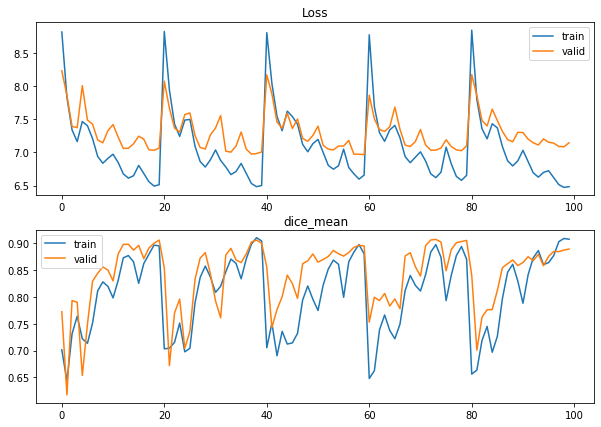

In [6]:
plot_loss_metrics(trainer_cv.loss_history, {'dice_mean':trainer_cv.dice_history})

## Check classes proportion in folds

In [23]:
img_list = os.listdir(TRAIN_PATH)
for img in exclude_img_list:
    img_list.remove(img)
img_list = sorted(img_list)

In [27]:
from collections import defaultdict

In [28]:
indices = list(range(len(img_list)))
print(len(indices))
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


for fold_num, (train_indices, valid_indices) in enumerate(kfold.split(indices)):
            
    print('*******************************************')
    print('Starting fold {}'.format(fold_num))
    print(f'train len={len(train_indices)}, valid len={len(valid_indices)}')
    train_cnt = defaultdict(int)
    valid_cnt = defaultdict(int)
    for ind in train_indices:
        el = train_dict[img_list[ind]]
        for cls in el:
            if el[cls]!= '':
                train_cnt[cls] += 1  
                
    for ind in valid_indices:
        el = train_dict[img_list[ind]]
        for cls in el:
            if el[cls]!= '':
                valid_cnt[cls] += 1  
                
    print(train_cnt)
    print(valid_cnt)

12524
*******************************************
Starting fold 0
train len=10019, valid len=2505
defaultdict(<class 'int'>, {3: 4108, 1: 711, 4: 645, 2: 186})
defaultdict(<class 'int'>, {1: 179, 2: 59, 3: 1027, 4: 155})
*******************************************
Starting fold 1
train len=10019, valid len=2505
defaultdict(<class 'int'>, {1: 702, 3: 4084, 4: 652, 2: 207})
defaultdict(<class 'int'>, {4: 148, 3: 1051, 1: 188, 2: 38})
*******************************************
Starting fold 2
train len=10019, valid len=2505
defaultdict(<class 'int'>, {1: 719, 3: 4122, 4: 647, 2: 196})
defaultdict(<class 'int'>, {4: 153, 1: 171, 2: 49, 3: 1013})
*******************************************
Starting fold 3
train len=10019, valid len=2505
defaultdict(<class 'int'>, {1: 708, 3: 4106, 4: 636, 2: 210})
defaultdict(<class 'int'>, {4: 164, 3: 1029, 1: 182, 2: 35})
*******************************************
Starting fold 4
train len=10020, valid len=2504
defaultdict(<class 'int'>, {1: 720, 4: 620